In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle

from sklearn.metrics import classification_report, roc_curve, precision_recall_curve
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.metrics import classification_report, roc_curve, precision_recall_curve,roc_auc_score, f1_score, confusion_matrix
from imblearn.over_sampling import SMOTE


%matplotlib inline

In [2]:
#get directory
df_train_path = os.path.join('data','df_train_scaled.csv')
df_test_path = os.path.join('data','df_test_scaled.csv')

#download in chunks
df_train = pd.read_csv(df_train_path,compression='zip', index_col=0)
df_test = pd.read_csv(df_test_path,compression='zip', index_col=0)

/ichec/home/users/ikunal95/.local/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
df_train.shape,df_test.shape

((1038769, 21), (194208, 21))

In [4]:
df_train.head()

,term,int_rate,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,loan_status,purpose,...,pub_rec,revol_bal,revol_util,mort_acc,pub_rec_bankruptcies,credit_hist,credit_line_ratio,balance_annual_inc,fico_avg_score,inst_amnt_ratio
0,-0.610627,0.172191,-0.165071,-0.326720,1.125480,0.447761,-0.425631,-1.304639,0,-0.280449,...,0,-0.544925,-1.031547,-0.312756,0,-0.506174,0.167560,-1.295442,-0.664064,0.758198
67,1.637546,1.587155,-1.679589,-1.849610,-1.094865,2.003926,0.925331,-1.304639,1,-1.129757,...,0,0.049260,1.652931,0.182998,0,1.812689,-0.286453,0.005808,-1.141442,-0.946936
109,-0.610627,0.172191,-0.165071,-0.326720,-1.094865,-1.108404,0.376406,1.110298,0,-0.280449,...,0,-0.041656,1.167090,-0.808510,0,-0.404217,-0.657446,-1.125453,-0.504937,0.757704
166,-0.610627,0.052647,-0.165071,-0.174431,-1.372409,-1.108404,-1.962332,1.110298,0,-0.280449,...,0,-0.489803,-0.990374,-0.808510,0,-1.029029,0.458129,-0.588348,0.449820,0.696767
240,-0.610627,0.359114,-0.165071,-0.479009,-1.094865,-1.108404,-0.040973,1.110298,0,-0.705103,...,0,-0.102644,0.117179,-0.808510,0,0.016681,-0.199473,-1.212870,-0.823190,0.854260


In [5]:
#target variable
target_col = 'loan_status'

#training variables
X_train = df_train.drop(columns=[target_col])
y_train = df_train[target_col]

#test variables
X_test = df_test.drop(columns=[target_col])
y_test = df_test[target_col]

drop_columns=['pub_rec','pub_rec_bankruptcies','emp_length','purpose','revol_bal','grade','int_rate']
X_train=X_train.drop(columns=drop_columns)
X_test =X_test.drop(columns=drop_columns)

In [6]:
X_train.shape,X_test.shape

((1038769, 13), (194208, 13))

In [7]:
from collections import Counter
counter = Counter(y_train)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)
#define the param grid
# Parameters of pipelines can be set using ‘__’ separated para
clf_grid = {
    'xgb__eta': [0.05, 0.1, 0.3],
    'xgb__max_depth': [3, 6, 12],
    'xgb__colsample_bytree': [0.9, 1.0],
    }
#define the pipeline
model_pipe = Pipeline([
    ('xgb', xgb.XGBClassifier(n_estimators=200,
                              n_jobs=-1, scale_pos_weight=estimate))
])
#define the classifer
clf = GridSearchCV(model_pipe,
                   clf_grid,
                   n_jobs=-1,
                   cv=3, 
                   verbose=50, 
                   scoring='roc_auc')
#fit to training data
clf.fit(X_train, y_train)

Estimate: 4.020
Fitting 3 folds for each of 18 candidates, totalling 54 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done   3 out of  54 | elapsed:  2.6min remaining: 43.6min
[Parallel(n_jobs=-1)]: Done   5 out of  54 | elapsed:  2.6min remaining: 25.5min
[Parallel(n_jobs=-1)]: Done   7 out of  54 | elapsed:  2.6min remaining: 17.5min
[Parallel(n_jobs=-1)]: Done   9 out of  54 | elapsed:  2.7min remaining: 13.3min
[Parallel(n_jobs=-1)]: Done  11 out of  54 | elapsed:  2.9min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  13 out of  54 | elapsed:  3.0min remaining:  9.4min
[Parallel(n_jobs=-1)]: Done  15 out of  54 | elapsed:  3.0min remaining:  7.8min
[Parallel(n_jobs=-1)]: Done  17 out of  54 | elapsed:  5.2min remaining: 11.2min
[Parallel(n_jobs=-1)]: Done  19 out of  54 | elapsed:  5.2min remaining:  9.7min
[Parallel(n_jobs=-1)]: Done  21 out of  54 | elapsed:  

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                                         

In [8]:
print("Best model parameters: \n")
print(clf.best_params_ )
print("Best model score: \n")
print(clf.best_score_)

Best model parameters: 

{'xgb__colsample_bytree': 0.9, 'xgb__eta': 0.05, 'xgb__max_depth': 6}
Best model score: 

0.7169512241208537


In [9]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[90304, 50226],
       [18424, 35254]])

In [10]:
fpr, tpr, thresholds = roc_curve(y_test,
                                 clf.predict_proba(X_test)[:,1],
                                 pos_label=1)

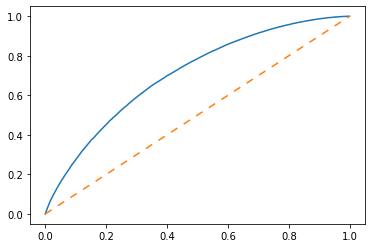

AUC: 0.705


In [11]:
plt.plot(fpr, tpr, label='XGB')
plt.plot([0,1], [0,1], label='No Discrimination', linestyle='-', dashes=(5, 5))
plt.show()

# calculate AUC
auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:,1])
print('AUC: %.3f' % auc)

In [12]:
f1_xgb = f1_score(y_test, y_pred)

print("f1_xgb (binary): {}\n".format(f1_xgb))
print(classification_report(y_test,y_pred))

f1_xgb (binary): 0.5066758648442777

              precision    recall  f1-score   support

           0       0.83      0.64      0.72    140530
           1       0.41      0.66      0.51     53678

    accuracy                           0.65    194208
   macro avg       0.62      0.65      0.62    194208
weighted avg       0.71      0.65      0.66    194208



In [14]:
#define location to save trained model
save_model_dir = os.path.join('models/xgb_cv_final.pkl')
print("Saving model at: {}".format(save_model_dir))

#save the model
with open(save_model_dir, 'wb') as handle:
    pickle.dump(clf,
                handle,
                protocol=3)

Saving model at: models/xgb_cv_final.pkl
